## 0. Revisar existencia de GPU con capacidad CUDA

In [ ]:
!nvidia-smi

Mon May  8 01:04:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Import de librerias

In [3]:
import tensorflow as tf
import io

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## 2. Carga de dataset

In [4]:
#Cargando dataset utilizando CIFAR10

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

169001437/169001437 [==============================] - 13s 0us/step


## 3. Preparacion de datos (Normalizar)

In [5]:
#Prepararar las variables de entrada y salida.

classes_of_interest = range(10)
train_idxs = [i for i, label in enumerate(y_train) if label in classes_of_interest]
test_idxs = [i for i, label in enumerate(y_test) if label in classes_of_interest]
x_train = x_train[train_idxs]
y_train = y_train[train_idxs]
x_test = x_test[test_idxs]
y_test = y_test[test_idxs]

nb_classes = len(np.unique(y_train))
print(nb_classes)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = to_categorical(y_train, len(classes_of_interest))
y_test = to_categorical(y_test, len(classes_of_interest))

10


### 3.1. Probando dataset

In [ ]:
x_train.shape

(5000, 32, 32, 3)

In [ ]:
x_test.shape

(1000, 32, 32, 3)

In [ ]:
y_train.shape

(5000, 10)

In [ ]:
y_test.shape

(1000, 10)

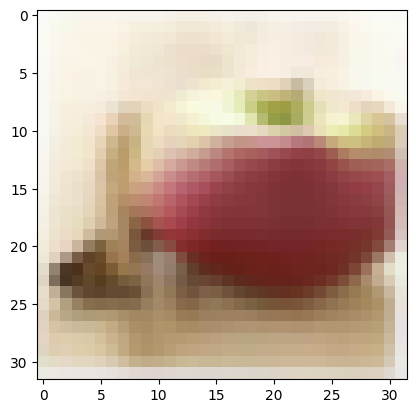

In [ ]:
plt.imshow(x_train[0])

In [ ]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

## 4. Modelos de red neuronal

### 4.1 DenseNet

In [6]:
model2 = Sequential()
densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])
model2.add(densenet)
model2.add(Flatten())
model2.add(Dense(1024))
model2.add(Activation('elu'))
model2.add(Dropout(0.5))
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))

29084464/29084464 [==============================] - 3s 0us/step


### 4.2 Compilar modelo

In [ ]:
model2.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

## 5. Entrenamiento

### 5.1 Modelo DenseNet

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)

# Fit data to model
history2 = model2.fit(datagen.flow(x_train, y_train, batch_size=50),
                    steps_per_epoch=x_train.shape[0] // 50,
                    epochs=600,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/600
100/100 [==============================] - 93s 150ms/step - loss: 1.9683 - accuracy: 0.3832 - val_loss: 1.3094 - val_accuracy: 0.5410
Epoch 2/600
100/100 [==============================] - 10s 96ms/step - loss: 1.1481 - accuracy: 0.6180 - val_loss: 1.0482 - val_accuracy: 0.6530
Epoch 3/600
100/100 [==============================] - 11s 107ms/step - loss: 0.8965 - accuracy: 0.7074 - val_loss: 0.7812 - val_accuracy: 0.7470
Epoch 4/600
100/100 [==============================] - 10s 105ms/step - loss: 0.7300 - accuracy: 0.7572 - val_loss: 0.5895 - val_accuracy: 0.7980
Epoch 5/600
100/100 [==============================] - 11s 107ms/step - loss: 0.6152 - accuracy: 0.7914 - val_loss: 0.4927 - val_accuracy: 0.8160
Epoch 6/600
100/100 [==============================] - 10s 101ms/step - loss: 0.5084 - accuracy: 0.8286 - val_loss: 0.4990 - val_accuracy: 0.8130
Epoch 7/600
100/100 [==============================] - 10s 100ms/step - loss: 0.4427 - accuracy: 0.8466 - val_loss: 0.4642 - 

### 5.3 Graficas de entrenamiento

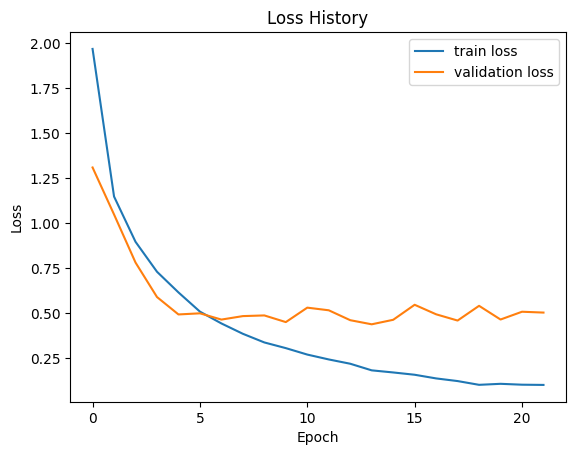

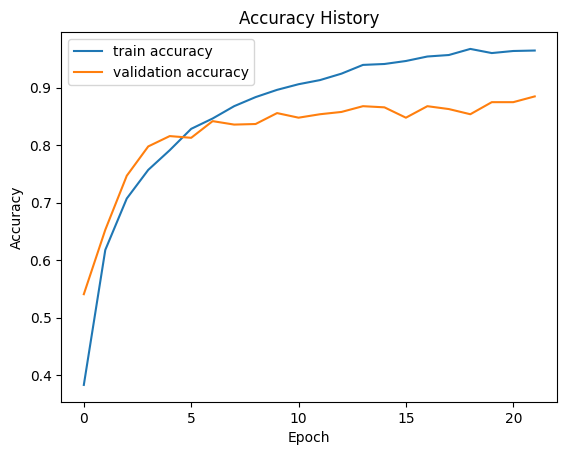

In [ ]:
# Plot the loss history
fig, ax = plt.subplots()
ax.plot(history2.history['loss'], label='train loss')
ax.plot(history2.history['val_loss'], label='validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss History')
ax.legend()
plt.show()

# Plot the accuracy history
fig, ax = plt.subplots()
ax.plot(history2.history['accuracy'], label='train accuracy')
ax.plot(history2.history['val_accuracy'], label='validation accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy History')
ax.legend()
plt.show()

### 6.1 Guardado

In [ ]:
model2.save('models/modelo_densenet.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


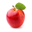

1/1 [==============================] - 0s 30ms/step
Etiqueta predicha: apple


In [9]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Cargar una imagen desde Google Drive
from PIL import Image

image_path = '/content/una-manzana-45309896.jpg'
image = Image.open(image_path)
image = image.resize((32, 32))
image.show()

# Preprocesar la imagen
import numpy as np

x = np.array(image)
x = x.reshape(1, 32, 32, 3)
x = x.astype('float32') / 255

# Realizar la predicción
prediction = model2.predict(x)
predicted_label = np.argmax(prediction)


class_names = [
        'apple', # id 0
        'aquarium_fish',
        'baby',
        'bear',
        'beaver',
        'bed',
        'bee',
        'beetle',
        'bicycle',
        'bottle',
        'bowl',
        'boy',
        'bridge',
        'bus',
        'butterfly',
        'camel',
        'can',
        'castle',
        'caterpillar',
        'cattle',
        'chair',
        'chimpanzee',
        'clock',
        'cloud',
        'cockroach',
        'couch',
        'crab',
        'crocodile',
        'cup',
        'dinosaur',
        'dolphin',
        'elephant',
        'flatfish',
        'forest',
        'fox',
        'girl',
        'hamster',
        'house',
        'kangaroo',
        'computer_keyboard',
        'lamp',
        'lawn_mower',
        'leopard',
        'lion',
        'lizard',
        'lobster',
        'man',
        'maple_tree',
        'motorcycle',
        'mountain',
        'mouse',
        'mushroom',
        'oak_tree',
        'orange',
        'orchid',
        'otter',
        'palm_tree',
        'pear',
        'pickup_truck',
        'pine_tree',
        'plain',
        'plate',
        'poppy',
        'porcupine',
        'possum',
        'rabbit',
        'raccoon',
        'ray',
        'road',
        'rocket',
        'rose',
        'sea',
        'seal',
        'shark',
        'shrew',
        'skunk',
        'skyscraper',
        'snail',
        'snake',
        'spider',
        'squirrel',
        'streetcar',
        'sunflower',
        'sweet_pepper',
        'table',
        'tank',
        'telephone',
        'television',
        'tiger',
        'tractor',
        'train',
        'trout',
        'tulip',
        'turtle',
        'wardrobe',
        'whale',
        'willow_tree',
        'wolf',
        'woman',
        'worm',
       
    ]

class_name = class_names[predicted_label]
print('Etiqueta predicha:', class_name)
